# **An Implementation of Signature Trading**

Team Member: 陳時賓、蔡文中、張履濃、陶威綸


# **Motivation**

1.  The Weaknesses of Classical Methods
    * Some of the assumptions made in regression analysis are quite restrictive.
    * Only a few simple models have closed-form solutions.
    * The predict-then-optimise composition in classical factor models can be prone to asymmetric errors that are compounded through the optimisation process.
2. The Advantages of Signature Method
    * A **data-driven** framework
    * Signature Method has closed-form solution.
    * Signature can universally approximate complex functions of trading strategy with infinitesimal error.
    * Adaptable for any asset or market factor process.






# **Abstract**

In the following project, we extend classical factor models into the Sig-Trading framework, obtaining a closed form solution to the optimal mean-variance Sig-Trading strategy and derive a clear intuition for portfolio managers to navigate and use this formula in a path-dependent context. Furthermore, by lifting the mean-variance optimisation into the lead-lag signature space , we bypass the necessity for any explicit prediction of returns, which is commonly required in traditional settings. This alleviates the accumulation of asymmetric residuals from the prediction phase, which can often be difficult to control. Moreover, the Sig-Trading framework simultaneously captures the joint signal-asset dynamics, whilst performing a dynamic optimisation which naturally incorporates a drawdown control within the objective function.

In the article, it just used Brownian motion to create its synthetic data. Here, we use third-party packages to generate synthetic data that corresponds more intuitively to the financial instruments we want to invest in.

In [ ]:
# prompt: download and import iisignature
#@title Loading data and some basic setup.
%%capture
!pip install iisignature
import iisignature
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import yfinance as yf
%matplotlib inline
sns.set()
from google.colab import drive

# 將 Google Drive 掛載到 Colab
# drive.mount('/content/gdrive')
# file_path = '/content/gdrive/My Drive/Colab Notebooks/SDV/sample100.csv'
file_path = "/content/sample100.csv"
data = pd.read_csv(file_path)
# some fixed numble
M = len(data.world.unique()) # number of 'world' we generated
L = len(data[data.world == data.world.unique()[0]]) # len of the sequence\
t = np.linspace(0, L-1, L)
# array for two asset
X = np.zeros((M,L)) # SPOT
Y = np.zeros((M,L)) # TSLA
# plug the data into the asset array
for i, world in enumerate(data.world.unique()):
  SPOT = data[data.world == world]['Adj Close_SPOT']
  TSLA = data[data.world == world]['Adj Close_TSLA']
  X[i] = SPOT
  Y[i] = TSLA

X = 100*(X.T/X[:,0]).T
Y = 100*(Y.T/Y[:,0]).T
market_path = np.zeros((M,2,21))
for m in range(M):
  market_path[m][0] = X[m,:21]
  market_path[m][1] = Y[m,:21]

# time augmentarion
def timeAug(X, time_path):
  '''
  input.shape = (D,L)
  output.shape = (D+1,L)
  '''
  D,L = X.shape
  X_hat = np.zeros((D+1, L))
  X_hat[0] = time_path
  X_hat[1:] = X
  return X_hat
def timeAug_multi_samples(X, time_path):
  '''
  input.shape = (M,D,L)
  output.shape = (M,D+1,L)
  '''
  M,D,L = X.shape
  X_hat = np.zeros((M, D+1, L))
  for m in range(M):
    X_hat[m] = timeAug(X[m], time_path)
  return X_hat

def required_level(trunc_level):
  return 2 * (trunc_level + 1)

# **Introduction of Signature**

Because the signature is a mathematical tool related to paths, let's first introduce some path processing methods that will be used.

### What's Signature?

Let's first introduce the **extended tensor algebra**.

* $T((ℝ^d))$ is the extended tensor algebra over $ℝ^d$, which is defined as
$$
T((ℝ^d)) := \left\{ a = (a_0,a_1,...,a_n,...) : a_n ∈ (ℝ^d)^{⊗n}\right\}
$$
where $a_0 ∈ (ℝ^d)^{⊗0} = ℝ, \\
a_1 ∈ (ℝ^d)^{⊗1} = ℝ^d, \\
a_2 ∈ (ℝ^d)^{⊗2} =
\left\{
\begin{pmatrix}
  a_{11} & \cdots & a_{1d} \\
  \vdots & \ddots & \vdots\\
  a_{d1} & \cdots & a_{dd}
  \end{pmatrix}  
  :
  a_{ij} ∈ ℝ
  \right\} \\
a_3 ∈ (ℝ^d)^{⊗3} = \text{the set of all the cubes with all components are real number}
$

* $T^{(N)}(ℝ^d)$ is the truncated tensor algebra of order N, which is defined as
$$T^{(N)}(ℝ^d) := \left\{ a = (a_0,a_1,...,a_n, 0, 0,...) : a_n ∈ (ℝ^d)^{⊗n}\right\}$$
where the dimension of $T^{(N)}(ℝ^d)$ is $1+d+d^2+...+d^N = \frac{d^{N+1}-1}{d-1}.$

<u>Definition</u>**(Signature)** : \\
Let $X:[0,T] → ℝ^d$ be a piecewise smooth path. The signature of X between time s and t is a map
$$
\begin{aligned}
𝕏 : \Delta_T &\to T((\mathbb{R}^d)) \\
(s,t) &\mapsto 𝕏_{s,t} := (1, 𝕏_{s,t}^1, ..., 𝕏_{s,t}^n, ...)
\end{aligned}
$$

where the n-th order of the signature is defined as
$$
𝕏_{s,t}^n:= \underset{s<u_1<...<u_n<t}{∫...∫}dX_{u_1}\otimes ...\otimes dX_{u_n} ∈ (ℝ^d)^{\otimes n}.
$$

The signature is a $T((ℝ^d))$-valued process,i.e

$$
𝕏_{0,T}^{<∞} =
\begin{pmatrix}
  𝕏_{0,T}^ {\color{blue}{∅}} & , &
  \begin{pmatrix}
  𝕏_{0,T}^{\color{blue}{1}} \\
  \vdots \\
  𝕏_{0,T}^{\color{blue}{d}}
  \end{pmatrix} & , &
  \begin{pmatrix}
  𝕏_{0,T}^{\color{blue}{11}} & \cdots & 𝕏_{0,T}^{\color{blue}{1d}} \\
  \vdots & \ddots & \vdots\\
  𝕏_{0,T}^{\color{blue}{d1}} & \cdots & 𝕏_{0,T}^{\color{blue}{dd}}
  \end{pmatrix}
  & , & ...
\end{pmatrix}
$$


The signature of a path can be truncated at any finite order $N$. We denote the truncated signature up to order $N$ as

\begin{equation}
\begin{aligned}
\mathbb{X}^{\leq N} &\colon \Delta_T \to T^{(N)}(\mathbb{R}^d) \\
&(s, t) \mapsto \mathbb{X}_{s,t} = (1, \mathbb{X}^1_{s,t}, \dots, \mathbb{X}^N_{s,t}).
\end{aligned}
\end{equation}


\\

Later, we will conduct a comparative evaluation of the Sig-Portfolio across various truncation orders, specifically comparing the outcomes at orders 0, 1,and 2.


In [ ]:
def sig_trans(X, trunc_level):
  D,L = X.shape
  X_sig = np.zeros((1,iisignature.siglength(D,trunc_level)))
  X_sig[0] = iisignature.sig(X.T, trunc_level)
  return X_sig.T

def sig_trans_path(X, trunc_level, zeroth_order=False):
  D,L = X.shape
  X_sig = np.zeros((L,iisignature.siglength(D,trunc_level)))
  for l in range(L):
    X_sig[l] = sig_trans(X[:,:l+1], trunc_level)[:,0]
  if zeroth_order:
    zero_order_path = np.ones((L,1))
    X_sig = np.append(zero_order_path, X_sig, axis=1)
    return X_sig.T
  return X_sig.T

def sig_trans_multi_samples(X, trunc_level):
  M,D,L = X.shape
  X_sig = np.zeros((M,iisignature.siglength(D,trunc_level),1))
  for m in range(M):
    X_sig[m] = sig_trans(X[m], trunc_level)
  return X_sig

def sig_trans_multi_samples_path(X, trunc_level):
  M,D,L = X.shape
  X_sig = np.zeros((M,iisignature.siglength(D,trunc_level),L))
  for m in range(M):
    X_sig[m] = sig_trans_path(X[m], trunc_level)
  return X_sig


### Indexing the Signature: Words

Words are the multi-indices in the tensor algebra. We use them to indicate the value with the corresponding index.
We will use the bold blue to represent the word $ \color{blue}{\text{w}}$.
Then we can define the space of all words, $𝑊(A_d) = \{∅, \color{blue}{1},..., \color{blue}{d}, \color{blue}{11}, \color{blue}{12}..., \color{blue}{1d},...,\color{blue}{dd},\color{blue}{111}, \color{blue}{112},... \}$, where $A_d = \{ \color{blue}{1},..., \color{blue}{d} \}$.
There are two operations on $𝑊(A_d)$, sum and concatenation, defined by
* sum:
$ \color{blue}{\text{w}} + \color{blue}{\text{v}} ∈ 𝑊(A_d) $
* concatenation:
If $\color{blue}{\text{w}}=\color{blue}{\text{w}_1}...\color{blue}{\text{w}_n}$
and
$\color{blue}{\text{v}}=\color{blue}{\text{v}_1}...\color{blue}{\text{v}_n}$,
then $\color{blue}{\text{w}} \color{blue}{\text{v}}
:= \color{blue}{\text{w}_1}...\color{blue}{\text{w}_n}\color{blue}{\text{v}_1}...\color{blue}{\text{v}_n} \in 𝑊(A_d).$







In [ ]:
def sig_word(path_dim, trunc_level, zero_order=False)->list:
  '''
  generate a list of words of the signature
  with the given truncation level and path dimension
  without zeroth order by default
  if zero_order=True, give first element with empty string, '',
  for the zeroth order
  '''
  if trunc_level == 0:
    return ['']
  if zero_order:
    return ['',*sig_word(path_dim,trunc_level)]
  if trunc_level == 1:
    return [str(i) for i in range(1, path_dim+1)]
  else:
    word_list = sig_word(path_dim, trunc_level-1)
    for index in sig_word(path_dim, trunc_level-1):
      for i in range(1,path_dim+1):
        if len(index) == trunc_level-1:
          word_list.append(index+str(i))
    return word_list

def mean_var_word(assets_num, facs_num, trunc_level)->list:
  '''
  give the word index we need for compute mu
  '''
  path_dim = 1 + assets_num + facs_num # 1 is for time augmentation
  f = lambda x: x + path_dim # shift operater
  words = sig_word(path_dim, trunc_level, zero_order=True)
  appended_words = []

  # +2 since we start the index from 1
  # e.g.['1','2','3','4','5','6']
  # the assets index start from 2
  for i in range(2, assets_num+2):
    for w in words:
      word = w + str(f(i))
      appended_words.append(word)
  return appended_words

def shuffle(wl="ua",wr="vb")->list:
  '''
  generate all the shuffled  elements of the given words
  '''
  addListStr = lambda l,s: [e+s for e in l]
  len_l = len(wl)
  len_r = len(wr)
  if len_l == 0: return [wr]
  if len_r == 0: return [wl]
  return addListStr(shuffle(wl[0:len_l-1],wr),wl[-1]) + addListStr(shuffle(wl,wr[0:len_r-1]),wr[-1])

# **Approach for Main Problem**

In this project, our goal is to find an optimal dynamic trading strategy that maximizes the expected utility of the PnL
$$
\begin{align*}
&\underset{\substack{(ξ_t)_{t\in[0,T]}}}{\mathrm{max}} \, \mathbb{E} \left( U(V_T) \right) \\
&\text{subject to some constraints}
\end{align*}
$$


Consider the widely known mean-variance utility function. The general mean-variance optimization can be formed as
$$
\underset{\substack{(ξ_t)_{t\in[0,T]}}}{\mathrm{max}} 𝔼 \left( V_T \right) - \frac{λ}{2} {\mathrm{Var}} \left( V_T\right)
$$
where the quantity
$$
V_T:=\sum_{m=1}^{d}\int_0^T ξ_t^m  \, dX_t^m
$$
is the strategy PnL at some future time $T$.

\\

<u>Explanation</u> \\
$ξ_t^m$ represents the size of the position held in the $m$-th asset at time $t$, and $dX_t^m$ denotes the corresponding price change of this asset. The product $ξ_t^mdX_t^m$ thus signifies the instantaneous profit (or loss) from holding the asset over an infinitesimal time interval. By integrating this product over the interval from 0 to $T$, we obtain the total profit (or loss) accrued by the $m$-th asset over the specified period. Summing these results across all assets yields the total portfolio profit and loss (PnL) over the time interval from 0 to $T$. \\

In fact, different from the common mean-variance optimization problem, it's difficult to slove this optimizaion problem since $ξ_t^m$ is dynamic. So the followings are some techniques to approach $ξ_t^m$.

\\



### **Why Use Signature ?**

In financial world, generally, $\xi$ ,which is the position, can be expressed by the function $\phi$ of the market process $Z$. Since $\phi$ might be complex and non-linear, it is difficult to obtain explicit form of $\phi$.
Signature is a excellent tool for approximating this complicated function.

To demonstrate how signatures can universally approximate complex functions in financial contexts, we have the following lemma:

<u>Lemma</u> **(The existence of the linear functional $ℓ$ to approximate the non-linear function $\phi$)** \\
Let
$
Z^{f}_{0,T} \subset K \subset C^{1-\text{var}} ([0, T], \mathbb{R}^d)$
be a compact set of market factor trajectories. Then for any exogenous signature trading strategy $\xi = \phi(\hat{Z}_{0,T})$ that acts on paths in $K$ and for every $\epsilon > 0$, there exists a linear functional $\ell \in T((\mathbb{R}^{N+d+1})^*)$, such that
$$
\underset{Z \in K}{sup} \Vert \phi(\hat{Z}_{0,T}) - ⟨\ell,\hat{ℤ}_{0,T}⟩ \Vert < ϵ.
$$

<u>Definition</u> (Market factor process) \\
Let $X = (X_t)_{t \in [0,T]}$ be a $d$-dimensional tradable underlying asset process. Then we define the (time-augmented) **market factor process** as the $(1 + d )$-dimensional process

$$
\hat{Z}_t := (t, X_t)
$$

where $ \hat{Z}$ means time-augmented process.


## **Linear functionals on the tensor algebra**

<u>Definition</u> \\

There is a natural pairing between the extended tensor algebra $T((\mathbb{R}^d) )$ and its dual space $T((\mathbb{R}^d)^*)$, by which we denote
$$
\langle \cdot , \cdot \rangle : T((\mathbb{R}^d)^*) \times T((\mathbb{R}^d)) \rightarrow \mathbb{R}
$$
and is given by
$$
\langle \ell, 𝕏 \rangle = \sum_{\color{blue}{\text{w}} \in W(A_d)} \ell_{\color{blue}{\text{w}}}𝕏^{\color{blue}{\text{w}}}
$$



## **Hoff Lead-Lag Processing**

<u>Definition</u>(Hoff Lead-Lag process) : \\
Let $\hat{X} : [0,T] → ℝ^{d+1}$ be the continuous time-augmented process of $X$, denoted by $\hat{X}_t = (t,X_t), t \in [0,T]$, discretely sampled at t = $t_0,...,t_{2N}$. The Hoff lead-lag transformed path is defined as the piecewise linear interpolation $\hat{X}^{LL}:[0,T] → ℝ^{2(d+1)} $ such that
$$(\hat{X}^{LL}_{t_i})^{2N}_{i=1} = (\hat{X}^{lead}_{t_i}, \hat{X}^{lag}_{t_i})^{2N}_{i=1},$$
where

$$
\begin{align*}
  \hat{X}^{lead}_t &= \left\{
          \begin{array}{ll}
            \hat{X}_{t_{k+1}}, & \quad \text{if } t \in [2k,2k+1] \\
            \hat{X}_{t_{k+1}}+2(t-(2k+1))(X_{t_{k+2}}-X_{t_{k+1}}) & \quad \text{if } t \in [2k+1,2k+\frac{3}{2}] \\
            \hat{X}_{t_{k+2}}, & \quad \text{if } t \in [2k+\frac{3}{2},2k+2] \\
          \end{array}
        \right.
\end{align*}
$$     
$$
\begin{align*}
  \hat{X}^{lag}_t &= \left\{
          \begin{array}{ll}
            \hat{X}_{t_k}, & \quad \text{if } t \in [2k,2k+\frac{3}{2}] \\
            \hat{X}_{t_k}+2(t-(2k+\frac{3}{2}))(X_{t_{k+1}}-X_{t_{k}}) & \quad \text{if } t \in [2k+\frac{3}{2},2k+2] \\
          \end{array}
        \right.
\end{align*}
$$ \\



### **Why is Lead-Lag Process Needed?**
Since we want to calculate the PnL of the strategy, by the following theorem, we can approximate the true Ito integral by integrating the observed Hoff lead-lag process instead. \\

<u>Theorem</u>**(Recovery of Ito integral using the Hoff lead-lag process)**  \\
Let $X = (X_t)_{t∈[0,T]}$ be a stochastic process on the filtered probability space$(Ω, 𝐹, (𝐹_t)_{t∈[0,T]}, ℙ)$.
Suppose observed X with discretely sampled over $ \{{t_i}\}_{i=0}^N $ is piecewise smooth. Let $\hat{X}^{LL} = (\hat{X}_{t_i}^{lead}, \hat{X}_{t_i}^{lag})_{i=1}^{2N}$ be a associated observed Hoff lead-lag transform of $\hat{X}$.
Let $\phi = (\phi_1,...,\phi_d)$ be continuous functions acting on paths of $X$, then we have \\
$$ \sum_{m=1}^{d} \int_{0}^{T}\phi^m(\hat{X}_{t}^{lag})d\hat{X}_{t}^{lead} → \int_{0}^{T}\phi(X_t)dX_t:= \sum_{m=1}^{d} \int_{0}^{T}\phi^m(X_t)dX_t^m \ \ as \ \  \underset{t_i,t_{i+1}}{max} |t_{i+1}-t_i| → 0,$$ \\
in either probability or $L^p$-norm. \\

In [ ]:
def hoff_trans2(col):
    tmp = col.repeat(4).reset_index(drop=True)[:-3]
    return pd.DataFrame({"lead":tmp,"lag":tmp.shift(-5)}).dropna()

# lead lag processing for data stream
def hoff_trans(path):

  L = path.shape[-1]
  path_LL = np.zeros((2, 2*L-1))
  lead = np.zeros(2*L-1)
  lag = np.zeros(2*L-1)
  for i in range(L-1):
    lag[2*i] = path[0,i]
    lag[2*i+1] = path[0,i]
  lag[-1] = path[0,-1]
  lead[:-1] = lag[1:]
  lead[-1] = path[0,-1]
  path_LL[0] = lag
  path_LL[1] = lead
  return path_LL

def hoff_trans_dims(X):

  D,L = X.shape
  X_LL = np.zeros((2*D,2*L-1))
  for d in range(D):
    path_LL = hoff_trans(np.array([X[d]]))
    X_LL[d] = path_LL[0]
    X_LL[d+D] = path_LL[1]
  return X_LL

def hoff_trans_multi_samples(X):

  M,D,L = X.shape
  X_LL = np.zeros((M,2*D,2*L-1))
  for m in range(M):
    X_LL[m] = hoff_trans_dims(X[m])
  return X_LL

example_diff = np.random.randn(1,21) # create a 1 dimensional Brownian motion path
example = np.zeros((1,21))
for i in range(21):
  example[0,i] = example[0,i-1] + example_diff[0,i]
result = hoff_trans(example)

[*********************100%%**********************]  1 of 1 completed


<Figure size 800x600 with 0 Axes>

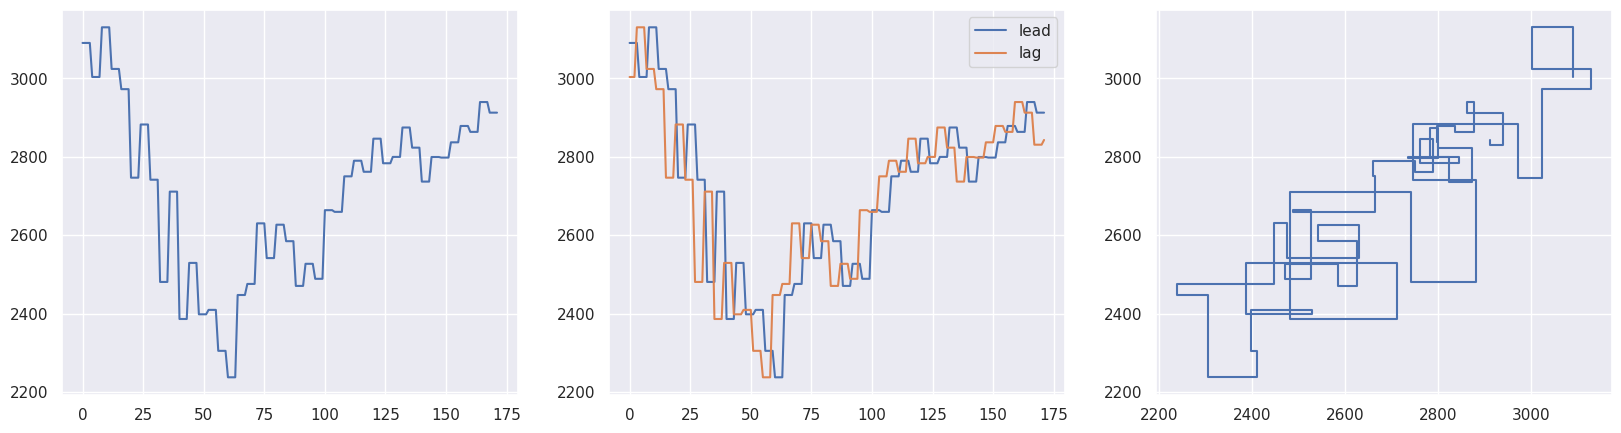

In [ ]:
plt.figure(figsize=(8,6))
start,end = "2020-03-02","2020-05-05"
spx = yf.download("^SPX", start=start, end=end, interval="1d")["Close"]
ll_spx = hoff_trans2(spx)
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].plot(ll_spx["lead"])
ax[1].plot(ll_spx["lead"],label="lead")
ax[1].plot(ll_spx["lag"],label="lag")
ax[2].plot(ll_spx["lead"],ll_spx["lag"])
ax[1].legend()

## **Closed Formed Formula for $V_T$**

### **Expected Value of $V_T$**

<u>Theorem</u>**(PnL of a $d$-asset signature trading strategy )**

Let $\hat{Z} = (t, X_t, f_t)_{t \in [0, T]}$ be the market factor process, where $X$ is a $d$-dimensional tradable stochastic process, and $f$ is an $N$-dimensional un-tradable factor process. \
Let $\ell_1, \ldots, \ell_d \in {T}((\mathbb{R}^{N+d+1})^*)$ and define our trading strategy as $\xi_t^m = \langle \ell_m, \hat{Z}_{0,t}^{<\infty} \rangle$ for $m = 1, \ldots, d$. Then, we have that the PnL of the strategy $\xi_{0, t}$ between time 0 and time $T$ can be represented as

$$ V_T=\displaystyle\sum_{m=1}^{d}\int_0^T \langle \ell_m, \hat{\mathbb{Z}}_{0,t} \rangle  \, dX_t^m \approx \displaystyle\sum_{m=1}^{d}\int_0^T \langle \ell_m, \hat{\mathbb{Z}}_{0,t}^{lag,<\infty} \rangle  \, dX_t^{m,lead} = \displaystyle\sum_{m=1}^{d}\langle \ell_m\color{blue}{f}(m), \hat{\mathbb{Z}}_{0,t}^{LL,<\infty} \rangle $$ \\

In order to simulate the true process of $X_t$, we construct 100 paths by SDV. And then calculate the expectation and the variance of these scenarios.

Now, due to the linearity of expectation, we are able to represent the expected PnL at time T as the following:
$$\mathbb{E}(V_T)=\displaystyle\sum_{m=1}^{d}\langle \ell_m\color{blue}{f}(m), \mathbb{E}(\hat{\mathbb{Z}}_{0,t}^{LL,<\infty} )\rangle $$

where
* $\mathbb{E}(\hat{\mathbb{Z}}_{0,t}^{LL,<\infty} )$ is the expected signature of the Hoff lead-lag transformation of $\hat{Z}$ . \\
* $\color{blue}{f}(m) : \{1,2,...,d\} → W(A_{2(N+d+1)})$ is a **shift operator** which maps the indices from the original signature terms to the signature terms of the time-augmented lead-lag process.






### **Variance of $V_T$**
<u>Lemma</u> \\
Let $X$ be a $d$-dimensional tradable stochastic process, and let $f$ be an $N$-dimensional un-tradable factor process. Define $\hat{Z}_t := (t, X_t, f_t)$ as the market factor process, and let $\ell_1, \ldots, \ell_d \in T((\mathbb{R}^{N+d+1})^*)$. Define our trading strategy as $\langle \ell_m, \hat{\mathbb{Z}}_{0,s}^{<\infty} \rangle$ for $m = 1, \ldots, d$. Let the expected PnL of the strategy $0, s$ between time 0 and time $T$ be defined as in (2.3). Then the Variance of the PnL at time $T$ is defined as

$$
\mathrm{Var}(V_T) = \sum_{m=1}^{d} \sum_{n=1}^{d} \left\langle \ell_m{\color{blue}{\text{f}}(m)}\ Ш \ \ell_n{\color{blue}{\text{f}}(n)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle - \left\langle \ell_m{\color{blue}{\text{f}}(m)} , \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle \left\langle \ell_n{\color{blue}{\text{f}}(n)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle \quad
$$

*proof:* \\
Note that
$
\mathrm{Var}(V_T) = \mathbb{E}(V_T^2)-[\mathbb{E}(V_T)]^2.
$
* $\mathbb{E}(V_T^2) = \sum_{m=1}^{d} \sum_{n=1}^{d} \left\langle \ell_m{\color{blue}{\text{f}}(m)}\ Ш \ \ell_n{\color{blue}{\text{f}}(n)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle $
by Shuffle product identity in  *A Primer on the Signature Method in Machine Learning* (stated below)
* $[\mathbb{E}(V_T)]^2 = \sum_{m=1}^{d} \sum_{n=1}^{d} \left\langle \ell_m{\color{blue}{\text{f}}(m)} , \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle \left\langle \ell_n{\color{blue}{\text{f}}(n)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle \quad $

In [ ]:
def mu_Sigma_sig(sig, assets_num, facs_num, trunc_level):
  '''
  compute mu_sig and Sigma_sig
  let d = 1 + assets_num + facs_num
  input
    sig.shape = (L)
    note L = siglength(2d,trunc_level)
  output
    mu_sig.shape = (d * assets_num)
    Sigma_sig.shape = (d * assets_num, d * assets_num)
  '''
  L = len(sig)
  d = 1 + assets_num + facs_num
  req_level = required_level(trunc_level)

  # the words list for lead lag sig path
  words_of_sig = sig_word(2*d, req_level)

  # the needy words list for mu and Sigma
  words_of_mu_Sigma = mean_var_word(assets_num, facs_num, trunc_level)
  len_mu_Sigma = len(words_of_mu_Sigma)

  mu_sig = ndarray_of_words(sig, words_of_sig, words_of_mu_Sigma)

  print(f'the total run times: {len_mu_Sigma}')

  Sigma_sig = np.zeros((len_mu_Sigma, len_mu_Sigma))

  for i, w in enumerate(words_of_mu_Sigma):
    for j, v in enumerate(words_of_mu_Sigma):
      shuffle_ndarray = ndarray_of_words(sig, words_of_sig, shuffle(v,w))
      shuffle_part = shuffle_ndarray.sum()

      index_w = words_of_sig.index(w)
      index_v = words_of_sig.index(v)
      multiple_part = sig[index_w]*sig[index_v]

      Sigma_sig[i,j] = shuffle_part - multiple_part
    print(f'\rnow is {i+1}',end='')
  print(f'\n')


  return mu_sig, Sigma_sig

def only_mu(sig, assets_num, facs_num, trunc_level):
  '''
  same as mu_Sigma_sig
  but without computing Sigma
  the purpose of this function is for computing backtest terminal PnL
  '''
  L = len(sig)
  d = 1 + assets_num + facs_num
  req_level = required_level(trunc_level)

  # the words list for lead lag sig path
  words_of_sig = sig_word(2*d, req_level)

  # the needy words list for mu and Sigma
  words_of_mu_Sigma = mean_var_word(assets_num, facs_num, trunc_level)
  len_mu_Sigma = len(words_of_mu_Sigma)

  mu_sig = ndarray_of_words(sig, words_of_sig, words_of_mu_Sigma)
  return mu_sig

def ndarray_of_words(sig, words_of_sig, words):
  '''
  pick up all the value of signature on the given words
  '''
  len_words = len(words)
  ndarray = np.zeros(len_words)
  for i, w in enumerate(words):
    index = words_of_sig.index(w)
    ndarray[i] = sig[index]
  return ndarray


### **Shuffle Product**
Shuffle is the act of moving things around from one position to another. So the two words
$\color{blue}{\text{w}} = \color{blue}{\text{w}_1}...\color{blue}{\text{w}_n}$
and
$\color{blue}{\text{v}} = \color{blue}{\text{v}_1}...\color{blue}{\text{v}_m}$
shuffle together
is the sum of all words of length $n+m$ that are permutations of
$\color{blue}{\text{w}_1},...,\color{blue}{\text{w}_n},\color{blue}{\text{v}_1},...,\color{blue}{\text{v}_m}$
such that both
$\color{blue}{\text{w}_1},...,\color{blue}{\text{w}_n}$
and
$\color{blue}{\text{v}_1},...,\color{blue}{\text{v}_m}$
appear in their original order. \\

<u>Definition</u>**(Shuffle Product)**  \\
The shuffle product Ш : $W(A_d) \times W(A_d)→ W(A_d)$ is defined by: \\
<center>
$\color{blue}{\text{u}}\color{blue}{\text{a}}$ Ш $\color{blue}{\text{v}}\color{blue}{\text{b}}$
$=$
($\color{blue}{\text{u}}$ Ш ${\color{blue}{\text{v}}\color{blue}{\text{b}}}$) $\color{blue}{\text{a}}$
$+$
($\color{blue}{\text{u}}\color{blue}{\text{a}}$ Ш $\color{blue}{\text{v}}$) $\color{blue}{\text{b}}$

$\color{blue}{\text{w}}$ Ш $\color{blue}{∅}$ = $\color{blue}{∅}$ Ш $\color{blue}{\text{w}}$ = $\color{blue}{\text{w}}$
</center>

for all words $\color{blue}{\text{u}},\color{blue}{\text{v}} ∈ W(A_d)$. \\
For example, $\color{blue}{\text{1}}\color{blue}{\text{2}}$ Ш $\color{blue}{\text{3}}\color{blue}{\text{4}} = $
$\color{blue}{\text{1234}}+\color{blue}{\text{1324}}+\color{blue}{\text{1342}}+\color{blue}{\text{3124}}+\color{blue}{\text{3142}}+\color{blue}{\text{3412}}$ \\


<u>Theorem</u>**(Shuffle Product Identity)** \\
For a path $ X: [a, b] \to \mathbb{R}^d $ and two multi-indices $ I = (i_1, \ldots, i_k) $ and $ J = (j_1, \ldots, j_m) $ with $ i_1, \ldots, i_k, j_1, \ldots, j_m \in \{1, \ldots, d\} $, it holds that
$$
S(X)^I_{a,b} S(X)^J_{a,b} = \sum_{K \in I Ш J} S(X)^K_{a,b}.
$$

where
$
S(X)_{a,b} = (1, S(X)^1_{a,b}, \ldots, S(X)^d_{a,b}, S(X)^{1,1}_{a,b}, S(X)^{1,2}_{a,b}, \ldots)
$
is the signature of a path $X$.

In [ ]:
def shuffle(wl="ua",wr="vb")->list:
  addListStr = lambda l,s: [e+s for e in l]
  len_l = len(wl)
  len_r = len(wr)
  if len_l == 0: return [wr]
  if len_r == 0: return [wl]
  return addListStr(shuffle(wl[0:len_l-1],wr),wl[-1]) + addListStr(shuffle(wl,wr[0:len_r-1]),wr[-1])

print(f'result of shuffle world 12 and 34 is {shuffle(wl="12",wr="34")}')

result of shuffle world 12 and 34 is ['3412', '3142', '1342', '3124', '1324', '1234']


# Optimal Signature Trading Strategy

<u>Theorem</u>**(Linear functional optimization)** \\
Denote $T \in \mathbb{N}$ the terminal time. Let $X$ be a $d$-dimensional tradable stochastic process and let $f$ be a $N$-dimensional un-tradable factor process. Define $\hat{Z}_t := (t, X_t, f_t)$ as the market factor process. Define a signature trading strategy $\xi^m_t$ through a linear functional on the signature of the market factor process, i.e., $\xi^m_t = \langle \ell^m, \hat{\mathbb{Z}}_{0,t} \rangle$. Then, for a given truncation level $M$, the mean-variance optimal signature trading strategy $\ell^* = (\ell^*_1, \ldots, \ell^*_d)$, $\ell^*_m \in T^{\left(M\right)}((\mathbb{R}^{N+d+1})^*)$, satisfies

$$
\ell_m^* :={\arg\max}_{\substack{\ell_m \in T^{(M)}\mathbb(({R}^{N+d+1})^*) \\ \operatorname{Var}(V_T) \leq \Delta}} \sum_{m=1}^d \left\langle \ell_m f(m), \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle,
\forall m \in \{1, \ldots, d\} \tag{3.1}
$$


and is given by
$$
\langle \ell^*_m, \mathbf{e}_\color{blue}{\text{w}} \rangle = \frac{((\Sigma^{\text{sig}})^{-1} \mu^{\text{sig}})_\color{blue}{wf(m)}}{2\lambda}, \quad m \in \{1, \ldots, d\}, \, \color{blue}{\text{w}} \in \mathcal{W}_{M}^{N+d+1}
$$

\\

where the variance-scaling parameter $\lambda$ is given by
$$
\lambda = \frac{1}{2\sqrt{\Delta}} \left( \sum_{m=1}^{d} \sum_{n=1}^{d} \sum_{\color{blue}{\text{w}}\in \mathcal{W}_{N+d+1}^{M}} \sum_{\color{blue}{\text{v}} \in \mathcal{W}_{N+d+1}^{M}} ((\Sigma^{\text{sig}})^{-1} \mu^{\text{sig}})_{\color{blue}{\text{wf}}(m)}((\Sigma^{\text{sig}})^{-1} \mu^{\text{sig}})_{\color{blue}{\text{vf}}(n)} \Sigma^{\text{sig}}_{\color{blue}{\text{wf}}(m),\color{blue}{\text{vf}}(n)}\right)^{\frac{1}{2}} \
$$

\\

We define the “Signature PnL attribution” as the $d \cdot |\mathcal{W}_{N+d+1}^{M}|$-length vector $\mu^{\text{sig}} = (\mu^{\text{sig}}_1, \ldots, \mu^{\text{sig}}_d)^{\top}$ as

\\

$$
\mu^{\text{sig}}_{\color{blue}{\text{wf}}(m)} = \left\langle {\color{blue}{\text{wf}}(m)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle, \forall \color{blue}{\text{w}} \in \mathcal{W}_{N+d+1}^{M}, m \in \{1, \ldots, d\}
$$

\\


and the “Signature PnL covariances” as the $d \cdot |\mathcal{W}_{M}^{N+d+1}| \times d \cdot |\mathcal{W}_{M}^{N+d+1}|$ matrix $\Sigma^{\text{sig}}$ as

\\


$$
\Sigma_{\color{blue}{\text{wf}}(m),\color{blue}{\text{vf}}(n)}^{\text{sig}} = \left\langle {\color{blue}{\text{wf}}(m)} Ш  {\color{blue}{\text{vf}}(n)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle - \left\langle {\color{blue}{\text{wf}}(m)} , \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle \left\langle {\color{blue}{\text{wf}}(m)}, \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle \quad
$$
$\forall \color{blue}{\text{w}}, \color{blue}{\text{v}} \in \mathcal{W}_{N+d+1}^{M},\text{and } m,n \in \{1, \ldots, d\} $

*Proof*

 In order to solve the constrained optimisation problem (3.1), we can introduce the Lagrangian

$$
\mathcal{L}(\ell_1, \ldots, \ell_d, \lambda) = \mathbb{E}(V_T) - \lambda(\text{Var}(V_T) - \Delta)
$$
Then we can compute the gradient of the Lagrangian with respect to $\langle \ell_m, \mathbf{e}_\color{blue}{\text{w}} \rangle$


$$
\frac{\partial \mathcal{L}(\ell_1, \ldots, \ell_d, \lambda)}{\partial \langle\ell_m, \mathbf{e}_\color{blue}{\text{w}}⟩} = \left\langle \color{blue}{\text{wf}}(m), \mathbb{E}\left( \hat{\mathbb{Z}}_{0,T}^{LL, <\infty} \right) \right\rangle - 2\lambda \sum_{n=1}^{d} \sum_{\color{blue}{\text{v}} \in \mathcal{W}^{M}_{N+d+1}} \left\langle \ell_n, e_\color{blue}{\text{v}} \right\rangle \Sigma^{\text{sig}}_{\color{blue}{\text{wf}}(m),\color{blue}{\text{vf}}(n)}
$$
By the definition of $\mu^{\text{sig}}$ and $\Sigma^{\text{sig}}$,
we can get
$$
\mu^{\text{sig}}_{\color{blue}{\text{wf}}(m)} = 2\lambda \sum_{n=1}^{d} \sum_{\color{blue}{v} \in {W}^{M}_{N+d+1}} \left\langle \ell_n, e_\color{blue}{v} \right\rangle \Sigma^{\text{sig}}_{\color{blue}{\text{wf}}(m),\color{blue}{\text{vf}}(n)}, \quad m \in \{1, \ldots, d\}, \color{blue}{\text{w}} \in \color{blue}{W}^{M}_{N+d+1}. \tag{3.4}
$$
Hence, assuming that $\Sigma^{\text{sig}}$ is invertible, we can solve (3.4) and obtain

$$
\langle \ell^*_m, \mathbf{e}_\color{blue}{\text{w}} \rangle = \frac{((\Sigma^{\text{sig}})^{-1} \mu^{\text{sig}})_\color{blue}{wf(m)}}{2\lambda}, \quad m \in \{1, \ldots, d\}, \, \color{blue}{\text{w}} \in \mathcal{W}_{M}^{N+d+1}
$$

### **The Example of $\mu^{sig}$ and $\Sigma^{sig}$ for order 0**

<u>Recall</u> \\
$\xi_t = \left\langle\ell, \hat{\mathbb{Z}}_{0,t}\right\rangle$ is a dynamic strategy that continuously updates its position at time $t$, depending on the value of $\hat{\mathbb{Z}}_{0,t}$. And the signature is defined at each level as

$$
\hat{\mathbb{Z}}_{0,t} = (1, \hat{\mathbb{Z}}^1_{0,t}, \ldots, \hat{\mathbb{Z}}^N_{0,t}, \ldots)
$$

We observe that the zero-th level of the signature is equal to 1 , so if we choose that level to trade , that is we set the truncated level of signature to 0. Therefore, for a d-asset portfolio, we obtain a static position for all time $t \in[0,T]$
$$
\xi_t^1 = \left\langle \ell_1, 1\right\rangle = \ell_1 \in \mathbb{R}, \quad \forall t \in [0, T]
$$ \\

$$
\vdots
$$

$$
\xi_t^d = \left\langle\ell_d, 1\right\rangle = \ell_d \in \mathbb{R}, \quad \forall t \in [0, T].
$$ \\

Using Theorem 3.1 , we have that $\ell= (\ell_1,\dots,\ell_d) \in \mathbb{R}^d $ , where
$$
\ell = \frac{1}{2\lambda} (\Sigma^{\text{sig}})^{-1} \mu^{\text{sig}}.
$$
Since we are trading with respect to the zero-th order of the signature, then the only word $\color{blue}{\text{w}}$ that we
are interested in is $\color{blue}{\text{w}}=\color{blue}{∅}$ , we can obtain

$$
\mu^{\text{sig}}_{\color{blue}{\text{wf}}(m)} = \left\langle \color{blue}{\text{wf}}(m), \mathbb{E}\left( \hat{\mathbb{Z}}^{\text{LL},<\infty}_{0,T} \right) \right\rangle, \quad \forall w \in W^{0}_{N+d+1}, m \in \{1, \ldots, d\}
$$

$$
= \left\langle\ \color{blue}{\text{f}}(m), \mathbb{E}\left( \hat{\mathbb{Z}}^{\text{LL},\leq1}_{0,T} \right) \right\rangle, \quad m \in \{1, \ldots, d\}.
$$

In fact , we can observe that the elements of the d-dimensional vector $\mu^{\text{sig}}$ are simply the expected returns of each asset, since
$$
\mu_m^{\text{sig}} = \left\langle \color{blue}f(m), \mathbb{E}\left( \hat{\mathbb{Z}}^{\text{LL}, \leq 1}_{0,T} \right) \right\rangle = \mathbb{E}\left( \int_{0}^{T} dX_t^m \right) = \mathbb{E}(X_T^m) - \mathbb{E}(X_0^m).
$$

Therefore, we have

$$
\mu^{\text{sig}} = \begin{bmatrix}
\mathbb{E}(X_T^1) - \mathbb{E}(X_0^1) \\
\vdots \\
\mathbb{E}(X_T^d) - \mathbb{E}(X_0^d)
\end{bmatrix}.
$$

which corresponds to the expected returns vector. Likewise, we obtain the $ d \times d $ matrix $\Sigma^{\text{sig}} $ as

$$
\Sigma^{\text{sig}}_{m,n} = \left\langle \color{blue}{\text{f}}(m) Ш \color{blue}{\text{f}}(n), \mathbb{E}\left(\hat{\mathbb{Z}}^{\text{LL}, \leq 2}_{0,T}\right) \right\rangle - \left\langle \color{blue}{\text{f}}(m), \mathbb{E}\left(\hat{\mathbb{Z}}^{\text{LL}, \leq 1}_{0,T}\right) \right\rangle \left\langle \color{blue}{\text{f}}(n), \mathbb{E}\left(\hat{\mathbb{Z}}^{\text{LL}, \leq 1}_{0,T}\right) \right\rangle,
$$

which naturally corresponds to the covariance matrix of the returns for each of the $ d$ assets.

Important but won't dicuss in this notebook is that we use the third party module [SDV](https://sdv.dev/) to create the synthetic data for our research.

And [this](https://colab.research.google.com/drive/1pnvD74i6aeysX9NAhv5Xu4xUjxJzBrmW#scrollTo=gkRfAuSCRx1c) is a notebook aboult how we get the synthetic data.

# Import Module and Set up Colab

In our work,
* $\color{blue}{1}$ represents the time(lag).
* $\color{blue}{2}$ represents the price(lag) of the first asset, SPOT.
* $\color{blue}{3}$ represents the price(lag) of the second asset, TSLA.
* $\color{blue}{f}(2) = \color{blue}{5}$ represents the price(lead) of the first asset, SPOT.
* $\color{blue}{f}(3) = \color{blue}{6}$ represents the price(lead) of the second asset, TSLA.

In [ ]:
# @title class sig_mv
def is_pos_def(x):
  '''
  input: 2-dimensional square matrix
  check the matrix is positive definite or not.
  '''
  return np.all(np.linalg.eigvals(x) > 0)


class sig_mv():
  def __init__(self, sig, assets_num, facs_num, trunc_level):
    self.trunc_level = trunc_level
    self.sig = sig
    self.assets_num = assets_num
    self.facs_num = facs_num
    if trunc_level == 0:
      self.words_length = 1
    else:
      self.words_length = 1 + iisignature.siglength(1+assets_num+facs_num,trunc_level)

  def generate_mv(self):
    self.mu, self.Sigma = mu_Sigma_sig(self.sig, self.assets_num, self.facs_num, self.trunc_level)

  def generate_mu(self):
    self.mu = only_mu(self.sig, self.assets_num, self.facs_num, self.trunc_level)

  def optimal_linear_fun(self, max_var):
    '''
    output the resulting mean with the given maximum variance
    and the corresponding linear functional
    the output is in the arrange of linear function, mean, variance
    '''

    # check the Sigma_sig is positive definite.
    if not is_pos_def(self.Sigma):
      print(f'the Sigma is not positive definite !!!')
      return 0

    inv_Sigma = np.linalg.inv(self.Sigma)
    Sigma_inv_dot_mu = inv_Sigma@self.mu

    scalar = max_var / (Sigma_inv_dot_mu@self.Sigma@Sigma_inv_dot_mu.T)

    opt_linear_fun = (scalar**0.5)*Sigma_inv_dot_mu

    mean = opt_linear_fun@self.mu
    var = opt_linear_fun@self.Sigma@opt_linear_fun.T

    return opt_linear_fun ,mean, var

# Implementation of Algorithm 1

Recalling the section of "Load the Synthetic Data", we store the sample market data in the variable, market_path.

In [ ]:
print(f'the shape of market_path is {market_path.shape}.')
print(f'')
print(f'\"{market_path.shape[0]}\" is for the sample number.')
print(f'\"{market_path.shape[1]}\" is for the path dimension.')
print(f'\"{market_path.shape[2]}\" is for the path length.')

the shape of market_path is (100, 2, 21).

"100" is for the sample number.
"2" is for the path dimension.
"21" is for the path length.


In [ ]:
sample_num = 100 # 0-100: choose the num of sample you want to.

Note that higher truncation level can cover the computation of lower trunction level.

E.g. if we have signature with truncation level 3, which leads to required level 6,

then we can compute $\mu^{sig}$ and $\Sigma^{sig}$ for truncation level from 1 to 2.

In [ ]:
X = market_path[:sample_num,:,:]
time_path = np.linspace(0, 1, 21)
trunc_level = 2
req_level = required_level(trunc_level)

X_hat = timeAug_multi_samples(X, time_path)
X_hat_LL = hoff_trans_multi_samples(X_hat)
X_hat_LL_sig = sig_trans_multi_samples(X_hat_LL,req_level)

exp_sig = np.sum(X_hat_LL_sig, axis=0)/sample_num

In [ ]:
trunc0 = sig_mv(exp_sig, 2, 0, 0)
trunc0.generate_mv()

the total run times: 2
now is 2



In [ ]:
trunc1 = sig_mv(exp_sig, 2, 0, 1)
trunc1.generate_mv()

the total run times: 8
now is 8



In [ ]:
trunc2 = sig_mv(exp_sig, 2, 0, 2)
trunc2.generate_mv()

the total run times: 26
now is 26



# Result
Let's take a look on the optimal expected returns with maximum variance = 2%.

In [ ]:
print(f'the optimal expected return is {trunc0.optimal_linear_fun(2)[1]}%')
print(f'='*50)
print(f'the optimal expected return is {trunc1.optimal_linear_fun(2)[1]}%')
print(f'='*50)
print(f'the optimal expected return is {trunc2.optimal_linear_fun(2)[1]}%')

the optimal expected return is 1.760148446410649%
the optimal expected return is 5.230042579253339%
the optimal expected return is 8.77167562892295%


Also, check the corresponding variance and linear functional.

In [ ]:
print(f'The corresponding variance is {trunc0.optimal_linear_fun(2)[2]}')
print(f'')
print(f'And the optimal linear func is \n{trunc0.optimal_linear_fun(2)[0]}')
print(f'='*70+f'\n')

print(f'The corresponding variance is {trunc1.optimal_linear_fun(2)[2]}')
print(f'')
print(f'And the optimal linear func is \n{trunc1.optimal_linear_fun(2)[0]}')
print(f'='*70+f'\n')

print(f'The corresponding variance is {trunc2.optimal_linear_fun(2)[2]}')
print(f'')
print(f'And the optimal linear func is \n{trunc2.optimal_linear_fun(2)[0]}')
print(f'='*70+f'\n')

The corresponding variance is 1.9999999999999996

And the optimal linear func is 
[-0.04248116 -0.07507869]

The corresponding variance is 2.0

And the optimal linear func is 
[-0.05054689 -0.23015558 -0.00071759 -0.00051965 -0.11378387  0.10198191
  0.00079953 -0.00345356]

The corresponding variance is 2.000000000000005

And the optimal linear func is 
[-2.12018712e-02 -1.07038749e+00 -5.86635470e-04 -3.55732574e-03
  1.84106175e+00 -8.54007861e-04  4.53738680e-03  3.15806466e-04
  1.36805081e-05 -4.82669764e-05  2.73792099e-03  3.64271493e-05
 -5.13723482e-05 -1.41476735e-01  2.45270020e-01  2.60069346e-03
  1.16200938e-03 -2.84759031e-01 -7.44432768e-03 -2.58360977e-02
  2.09553622e-03 -2.66686690e-05  9.31583748e-05 -1.01765442e-02
 -2.98195843e-04 -1.09232972e-04]



We can see that the corresponding variance is the maximum variance we set.

## Plot the Efficient Frontier and some Possible Portfolios

In [ ]:
def generate_opt_and_random_ports(sig_mv: sig_mv, point_num, ran_point_num, max_var=2.5, delta_scalar=1):
  var_linespace = np.linspace(0,max_var,point_num)
  L = sig_mv.words_length * sig_mv.assets_num
  opt_mean = np.zeros(point_num)
  opt_lf = np.zeros((point_num,L))
  opt_var = var_linespace
  for i, V in enumerate(var_linespace):
    opt_lf[i,:] = sig_mv.optimal_linear_fun(V)[0]
    opt_mean[i] = sig_mv.optimal_linear_fun(V)[1]

  ran_lf = np.zeros((ran_point_num,L))
  ran_mean = np.zeros(ran_point_num)
  ran_var = np.zeros(ran_point_num)
  delta = np.zeros(L)

  with np.printoptions(linewidth=np.inf):
    print(f'the total runtime for random is {ran_point_num}')
    for i, step in enumerate(np.linspace(0,0.01,ran_point_num)):
      for j in range(L):
        delta[j] = random.randint(0, 1)
      ran = random.randint(0, point_num-1)
      lf = opt_lf[ran,:] + delta_scalar*delta*step
      print(f'\rnow is {i+1}',end='')
      ran_var[i] = lf@sig_mv.Sigma@lf.T
      ran_mean[i] = lf@sig_mv.mu
  print(f'\rfinished !')

  return opt_lf, opt_mean, opt_var, ran_lf, ran_mean, ran_var

In [ ]:
opt_lf0, opt_mean0, opt_var0, ran_lf0, ran_mean0, ran_var0 = generate_opt_and_random_ports(trunc0, 100, 20000, delta_scalar=200)
opt_lf1, opt_mean1, opt_var1, ran_lf1, ran_mean1, ran_var1 = generate_opt_and_random_ports(trunc1, 100, 10000)
opt_lf2, opt_mean2, opt_var2, ran_lf2, ran_mean2, ran_var2 = generate_opt_and_random_ports(trunc2, 100, 200000)

the total runtime for random is 20000
finished !
the total runtime for random is 10000
finished !
the total runtime for random is 200000
finished !


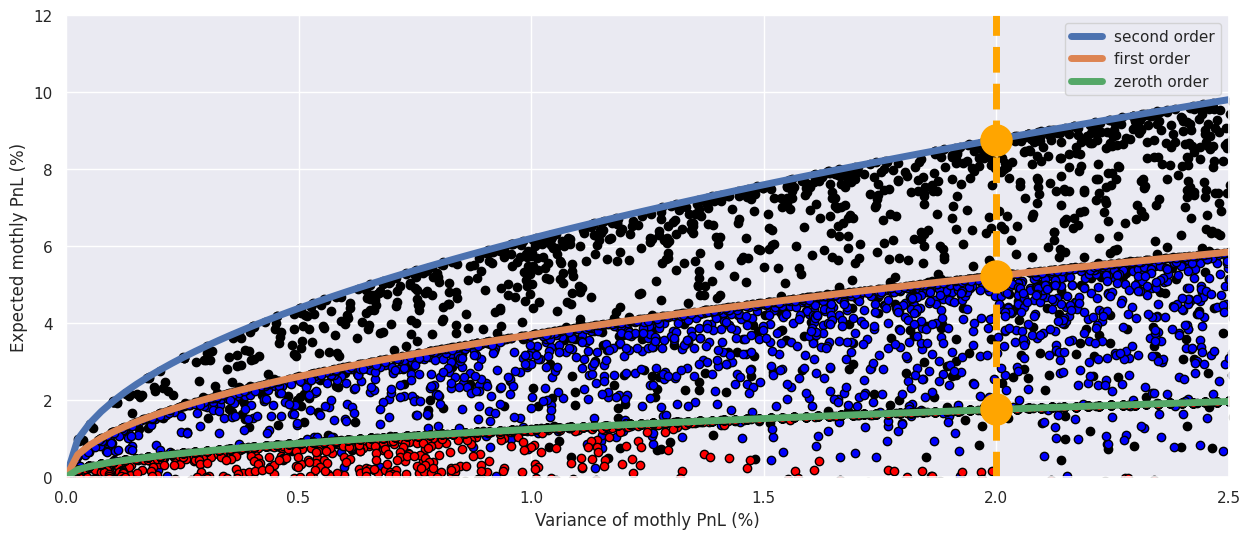

In [ ]:
plt.figure(figsize=(15,6))

plt.scatter(ran_var2, ran_mean2, color='black', edgecolors='black')
plt.plot(opt_var2, opt_mean2, linewidth=5, label='second order')

plt.scatter(ran_var1, ran_mean1, color='blue', edgecolors='black')
plt.plot(opt_var1, opt_mean1, linewidth=5, label='first order')

plt.scatter(ran_var0, ran_mean0, color='red', edgecolors='black')
plt.plot(opt_var0, opt_mean0, linewidth=5, label='zeroth order')

y_values = np.linspace(0, 12, 100)
x_values = np.full_like(y_values, 2)

plt.plot(x_values, y_values, color='orange', linewidth=5, linestyle='--')

opt_y = np.zeros(3)
opt_x = np.full_like(opt_y, 2)
opt_y[0] = trunc0.optimal_linear_fun(2)[1]
opt_y[1] = trunc1.optimal_linear_fun(2)[1]
opt_y[2] = trunc2.optimal_linear_fun(2)[1]

plt.scatter(opt_x, opt_y, color='orange', s=500, zorder=10)

plt.xlim(0, 2.5)
plt.ylim(0, 12)

plt.xlabel('Variance of mothly PnL (%)')
plt.ylabel('Expected mothly PnL (%)')

plt.legend()
plt.show()

# Algorithm 2: Compute the Position $\xi$


In [ ]:
import yfinance as yf
ticker = ['SPOT', 'TSLA']
start_date = '2022-2-1'
end_date = '2022-3-1'
data = yf.download(ticker, start_date, end_date)

[*********************100%%**********************]  2 of 2 completed


In [ ]:
l = len(data['Adj Close'])

In [ ]:
market_path = np.zeros((2,l))
market_path[0] = data['Adj Close']['SPOT']
market_path[1] = data['Adj Close']['TSLA']

In [ ]:
market_path = 100*(market_path.T/market_path[:,0]).T

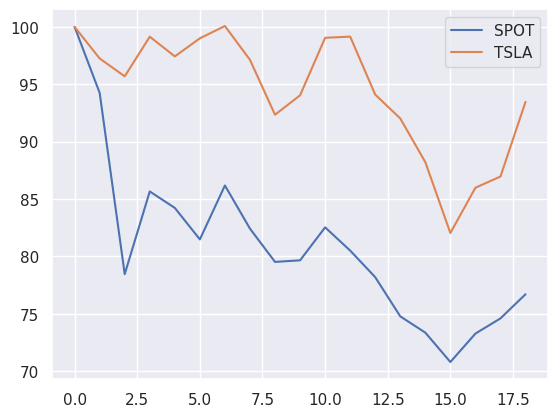

In [ ]:
plt.plot(market_path[0], label='SPOT')
plt.plot(market_path[1], label='TSLA')
plt.legend()

$
1. \text{ Create the } (N + d + 1)\text{-dimensional market factor paths and apply time-augmentation to obtain } \hat{Z}_{s \in [0,t]}.
$
$
2. \text{ Compute the truncated signature of the stopped market factor path, } \hat{Z}_{0,t}.
$
$
3. \text{ For each asset } m \in \{1, \ldots, d\}, \text{ obtain the optimal strategy } \xi^m_t \text{ by applying an inner product of the terms of } \ell_m \text{ to the signature of the time-augmented market path.}
$
$$\xi^m_t = \langle \ell_m, \hat{\mathbb{Z}}_{0,t} \rangle
$$

In [ ]:
time_path = np.linspace(0, 1, l)

In [ ]:
Z_hat = timeAug(market_path, time_path)
Z_hat_sig = sig_trans_path(Z_hat, 3, zeroth_order=True)

In [ ]:
Z_hat_sig.shape

(40, 19)

In [ ]:
def diff(path):
  A = np.zeros(len(path))
  A[1:] = path[:-1]
  return path - A

In [ ]:
# xi is for the position
class xi():
  def __init__(self, sig_mv: sig_mv, market_path, time_path, max_var=2):
    self.sig_mv = sig_mv
    self.trunc_level = sig_mv.trunc_level
    self.asset_num = sig_mv.assets_num
    self.facs_num = sig_mv.facs_num
    self.market_path = market_path
    self.time_path = time_path
    self.max_var = max_var
    self.olf = sig_mv.optimal_linear_fun(max_var)[0]
    self.xi = self.generate_xi()
    self.VT = self.compute_VT()

  def generate_xi(self):
    dim = 1 + self.asset_num + self.facs_num
    olf = self.olf
    hat = timeAug(self.market_path, self.time_path)
    sig_hat = sig_trans_path(hat, required_level(self.trunc_level), zeroth_order=True)
    xi = np.zeros((self.asset_num, sig_hat.shape[1]))

    if self.trunc_level == 0:
      lf_dim_each_assets = 1
    else:
      lf_dim_each_assets = iisignature.siglength(dim, self.trunc_level) + 1

    for i, step in enumerate(range(0, len(olf), lf_dim_each_assets)):
      xi[i] = olf[step:step+lf_dim_each_assets]@sig_hat[:lf_dim_each_assets,:]
    return xi

  def compute_VT(self):
    hat = timeAug(self.market_path, self.time_path)
    ll_hat = hoff_trans_dims(hat)
    sig_ll_hat = sig_trans(ll_hat, required_level(self.trunc_level))
    sig_backtest = sig_mv(sig_ll_hat,self.asset_num,self.facs_num,self.trunc_level)
    sig_backtest.generate_mu()
    VT = self.olf@sig_backtest.mu # olf = optimal linear functional
    return VT

In [ ]:
xi0 = xi(trunc0, market_path, time_path)
xi1 = xi(trunc1, market_path, time_path)
xi2 = xi(trunc2, market_path, time_path)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


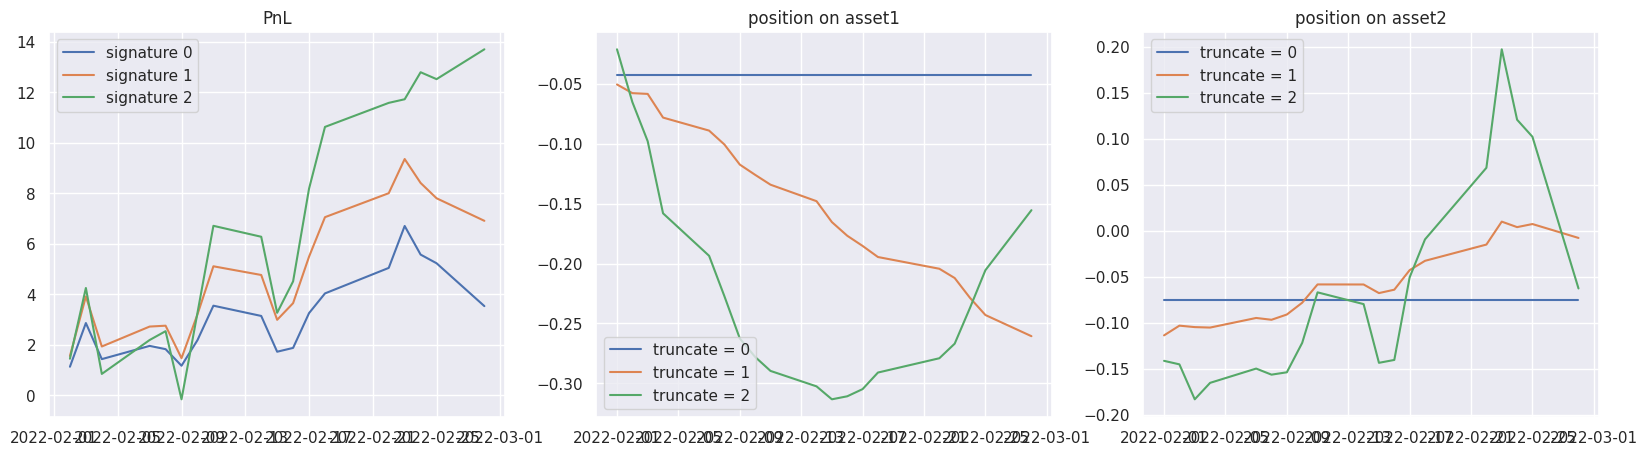

In [ ]:
# Example usage
from datetime import datetime, timedelta
stock = yf.download("SPOT", start=start_date, end=end_date)
stock2 = yf.download("TSLA", start=start_date, end=end_date)
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
tmp = xi2
for tmp in zip([0,1,2],[xi0,xi1,xi2]):
  stock["position"] = pd.Series(tmp[1].xi[0],index=stock.index)
  stock["d_price"] = stock["Adj Close"].diff()
  stock2["position"] = pd.Series(tmp[1].xi[1],index=stock2.index)
  stock2["d_price"] = stock2["Adj Close"].diff()
  ax[0].plot(((stock["position"].shift(1) * stock["d_price"]).cumsum()+(stock2["position"].shift(1) * stock2["d_price"]).cumsum()), label=f"signature {tmp[0]}")
  ax[1].plot(stock["position"],label=f"truncate = {tmp[0]}")
  ax[2].plot(stock2["position"],label=f"truncate = {tmp[0]}")
ax[0].set_title("PnL")
ax[1].set_title("position on asset1")
ax[2].set_title("position on asset2")
for x in ax: x.legend()

In [ ]:
print(f'the final return of order 2 is {xi2.VT}')

the final return of order 2 is 5.493505754902337


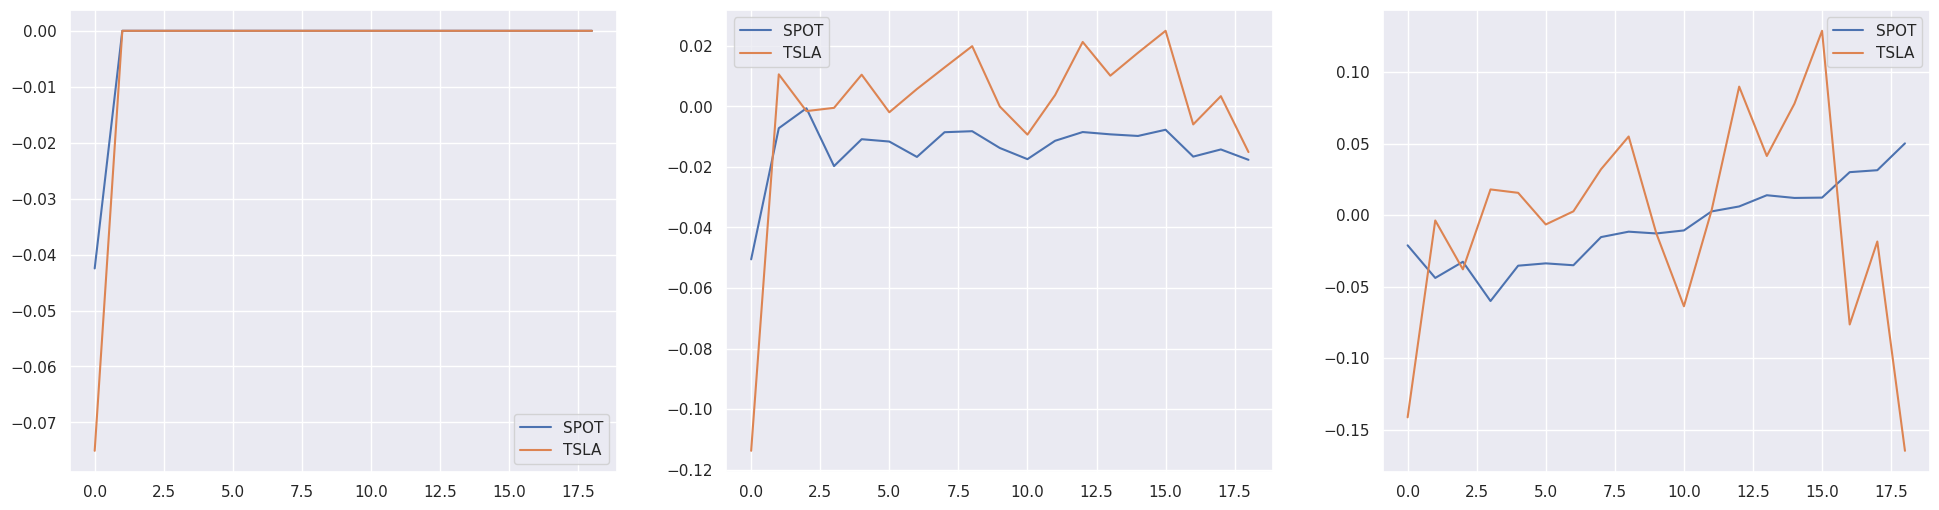

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

axs[0].plot(diff(xi0.xi[0]), label='SPOT')
axs[0].plot(diff(xi0.xi[1]), label='TSLA')
axs[0].legend()

axs[1].plot(diff(xi1.xi[0]), label='SPOT')
axs[1].plot(diff(xi1.xi[1]), label='TSLA')
axs[1].legend()

axs[2].plot(diff(xi2.xi[0]), label='SPOT')
axs[2].plot(diff(xi2.xi[1]), label='TSLA')
axs[2].legend()

In [ ]:
data = pd.read_csv(file_path)
# some fixed numble
M = len(data.world.unique()) # number of 'world' we generated
L = len(data[data.world == data.world.unique()[0]]) # len of the sequence\
t = np.linspace(0, L-1, L)

# array for two asset
X = np.zeros((M,L)) # SPOT
Y = np.zeros((M,L)) # TSLA

In [ ]:
# plug the data into the asset array

for i, world in enumerate(data.world.unique()):
  SPOT = data[data.world == world]['Adj Close_SPOT']
  TSLA = data[data.world == world]['Adj Close_TSLA']

  X[i] = SPOT
  Y[i] = TSLA

In [ ]:
X = 100*(X.T/X[:,0]).T
Y = 100*(Y.T/Y[:,0]).T

In [ ]:
market_path = np.zeros((M*12,2,19))
j = 0
for m in range(M):
  for i in range(12):
    market_path[j][0] = X[m,21+19*i:21+19*(i+1)]
    market_path[j][1] = Y[m,21+19*i:21+19*(i+1)]
    j = j+1

In [ ]:
market_path.shape

(1200, 2, 19)

In [ ]:
VT = np.zeros((3, M*12))
for i in range(M*12):
  VT[0,i] = xi(trunc0, market_path[i], time_path).VT
  VT[1,i] = xi(trunc1, market_path[i], time_path).VT
  VT[2,i] = xi(trunc2, market_path[i], time_path).VT

In [ ]:
from scipy.stats import norm

mean = np.zeros(3)
stdev = np.zeros(3)

for i in range(3):
  mean[i] = VT[i].mean()
  stdev[i] = VT[i].std()
  print(f'the backtesting of order{i} have mean return of {mean[i]}, and the std of return is {stdev[i]}')


the backtesting of order0 have mean return of 0.194003823234776, and the std of return is 1.0750296652346762
the backtesting of order1 have mean return of 0.7111528793804673, and the std of return is 1.9535238986279593
the backtesting of order2 have mean return of 1.3738422955770428, and the std of return is 4.253340111789273


In [ ]:
%%capture
!pip install fitter

In [ ]:
# Fitting the dist
from fitter import Fitter
cauchy_param = [0]*3 # dummy list
for i in range(3):
  f = Fitter(VT[i],distributions=['cauchy'], xmin=-11, xmax=11, bins=50)  # create a Fitter instance
  f.fit()  # Use fit fn to fit the dist
  # f.summary()  # output the fitting result
  cauchy_param[i] = f.get_best()['cauchy']

In [ ]:
# Plot between -11 and 11
x_axis = np.arange(-11, 11, 0.01)

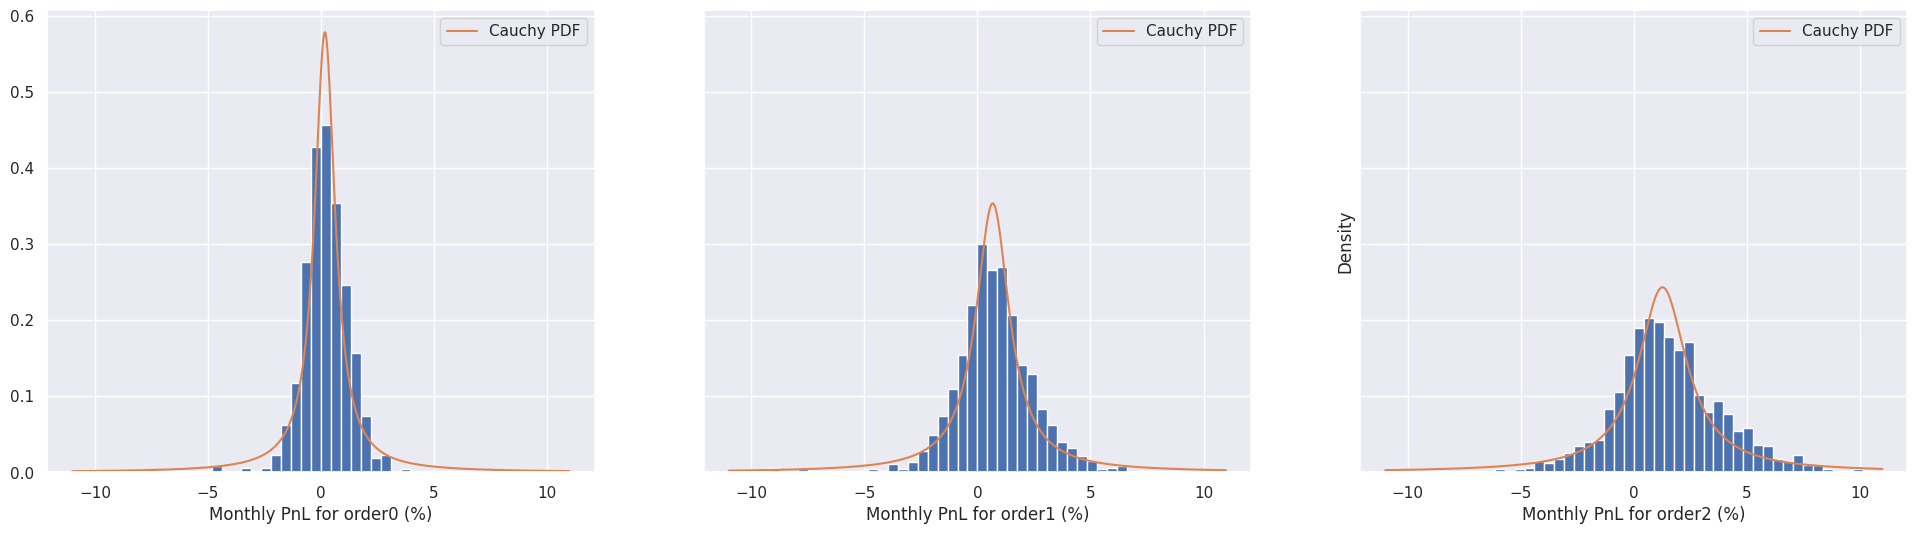

In [ ]:
from scipy.stats import cauchy

pdf = [0]*3
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24,6))
plt.ylabel('Density')
for i in range(3):
  params = cauchy_param[i]
  pdf[i] = cauchy.pdf(x_axis, loc=params['loc'], scale=params['scale'])

  axs[i].hist(VT[i], bins=50, density=True,range=(-11, 11))
  axs[i].plot(x_axis, pdf[i], label='Cauchy PDF')
  axs[i].set_xlabel(f'Monthly PnL for order{i} (%)')
  axs[i].legend()

plt.show()

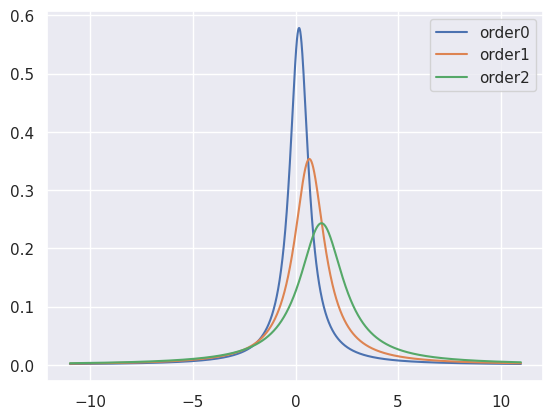

In [ ]:
for i in range(3):
  plt.plot(x_axis, pdf[i], label=f'order{i}')
plt.legend()
plt.show()

# Conclusion
* Utilized third-party software named SDV for data generation.
* Explored the signature method as a robust tool for analyzing time series data.
* Highlighted the signature method's advantage over traditional predict-then-optimize models, which often have compounded errors in estimating regression coefficients.
* Noted the reduction of error using the signature method, approaching nearly zero.
* Emphasized the method's facilitation of dynamic position adjustments, an improvement over static models.
* Observed that as the number of orders (truncation level) increases, the distribution of returns tends to shift to the right.
* Under constant probabilities of loss, the expected return on investment rises, illustrating the method's effectiveness.


This notebook is a slightly implementation of [Signature Trading: A Path-Dependent Extension of the Mean-Variance Framework with Exogenous Signals](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4541830).

Also, to see through the core of signature, we read a lot from [A Primer on the Signature Method in Machine Learning](https://arxiv.org/abs/1603.03788)